In [2]:
import matplotlib
import operator
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import joblib

matplotlib.rcParams['font.serif'] = 'Times New Roman'
matplotlib.rcParams['font.family'] = "serif"
matplotlib.rcParams['font.size'] = 10

# import custom functions
from functions_statistical_performance import *

In [3]:

# True to exactly reproduce the results presented in the paper (the same splits for cross-validation)
reproduceflag=False

# Loading Training Data

In [4]:
# log-transformed nutrient content per 100 grams
RFFNDDS=pd.read_csv('./input_data/FNDDS_2009-10_Training_Data.csv')
RFFNDDS

,Protein,Total Fat,Carbohydrate,Alcohol,Water,Caffeine,Theobromine,"Sugars, total","Fiber, total dietary",Calcium,...,Total flavones,Total flavonols,Total isoflavones,Food_code,Main_food_description,catnumb,catname,novaclass,macroclass,pythonlabel
0,-20.000000,-20.000000,-20.000000,-20.0,-1.609438,-20.0,-20.0,-20.000000,-20.0,-3.729701,...,-20.0,-20.0,-20.0,2047,"Salt, table",0,addition1516,2,Other,1
1,0.029559,1.477049,1.930071,-20.0,4.471639,-20.0,-20.0,1.930071,-20.0,-3.442019,...,-20.0,-20.0,-20.0,11000000,"Milk, human",9602,Human milk,1,Milk,0
2,1.187843,0.647103,1.578979,-20.0,4.491441,-20.0,-20.0,1.625311,-20.0,-2.128632,...,-20.0,-20.0,-20.0,11100000,"Milk, NFS",1004,"Milk, reduced fat",1,Milk,0
3,1.147402,1.178655,1.568616,-20.0,4.478813,-20.0,-20.0,1.619388,-20.0,-2.180367,...,-20.0,-20.0,-20.0,11111000,"Milk, cow's, fluid, whole",1002,"Milk, whole",1,Milk,0
4,1.131402,1.241269,1.495149,-20.0,4.479607,-20.0,-20.0,1.495149,-20.0,-2.292635,...,-20.0,-20.0,-20.0,11111100,"Milk, cow's, fluid, whole, low-sodium",1002,"Milk, whole",1,Milk,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7249,-20.000000,-20.000000,-1.897120,-20.0,4.603669,-20.0,-20.0,-20.000000,-20.0,-6.907755,...,-20.0,-20.0,-20.0,94100200,"Water, bottled, sweetened, with low or no calo...",7802,Flavored or carbonated water,4,Other,3
7250,-20.000000,-20.000000,1.504077,-20.0,4.547965,-20.0,-20.0,1.504077,-20.0,-4.074542,...,-20.0,-20.0,-20.0,94100300,"Water, fruit flavored, sweetened, with high fr...",7802,Flavored or carbonated water,4,Other,3
7251,-20.000000,-20.000000,0.198851,-20.0,4.592895,-20.0,-20.0,0.198851,-20.0,-6.907755,...,-20.0,-20.0,-20.0,94210100,Propel Water,7804,Enhanced or fortified water,4,Other,3
7252,-20.000000,-20.000000,1.702928,-20.0,4.547965,-20.0,-20.0,1.702928,-20.0,-4.074542,...,-20.0,-20.0,-20.0,94210200,Glaceau Water,7804,Enhanced or fortified water,4,Other,3


In [5]:
# total nutrient list
nl=list(RFFNDDS.columns)
nl=nl[0:-7]
len(nl)

99

In [6]:
# Nutrition Facts
nutrition_facts=['Protein','Total Fat','Carbohydrate','Sugars, total','Fiber, total dietary','Calcium','Iron', 'Sodium','Retinol','Carotene, beta',
 'Carotene, alpha','Cryptoxanthin, beta','Vitamin C','Cholesterol', 'Fatty acids, total saturated'];
VitaminA=['Retinol','Carotene, beta','Carotene, alpha','Cryptoxanthin, beta']

RFFNDDSNF=RFFNDDS[nutrition_facts]
RFFNDDSNF['Total Vitamin A']=RFFNDDS[VitaminA].apply(np.exp).sum(axis=1).apply(np.log)
RFFNDDSNF=RFFNDDSNF.drop(VitaminA, axis=1)

print(len(RFFNDDSNF.columns))
print(RFFNDDSNF.columns)
RFFNDDSNF

12
Index(['Protein', 'Total Fat', 'Carbohydrate', 'Sugars, total',
       'Fiber, total dietary', 'Calcium', 'Iron', 'Sodium', 'Vitamin C',
       'Cholesterol', 'Fatty acids, total saturated', 'Total Vitamin A'],
      dtype='object')


C:\Users\harel\PycharmProjects\MLFoodProcessing-auto\venv\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,Protein,Total Fat,Carbohydrate,"Sugars, total","Fiber, total dietary",Calcium,Iron,Sodium,Vitamin C,Cholesterol,"Fatty acids, total saturated",Total Vitamin A
0,-20.000000,-20.000000,-20.000000,-20.000000,-20.0,-3.729701,-8.016418,3.657337,-20.000000,-20.000000,-20.000000,-18.613706
1,0.029559,1.477049,1.930071,1.930071,-20.0,-3.442019,-10.414313,-4.074542,-5.298317,-4.268698,0.697637,-9.610756
2,1.187843,0.647103,1.578979,1.625311,-20.0,-2.128632,-10.414313,-3.123566,-9.210340,-4.961845,0.143234,-9.772387
3,1.147402,1.178655,1.568616,1.619388,-20.0,-2.180367,-10.414313,-3.146555,-20.000000,-4.605170,0.623261,-9.864188
4,1.131402,1.241269,1.495149,1.495149,-20.0,-2.292635,-9.903488,-5.809143,-7.013116,-4.268698,0.767327,-10.260045
...,...,...,...,...,...,...,...,...,...,...,...,...
7249,-20.000000,-20.000000,-1.897120,-20.000000,-20.0,-6.907755,-20.000000,-5.809143,-20.000000,-20.000000,-20.000000,-18.613706
7250,-20.000000,-20.000000,1.504077,1.504077,-20.0,-4.074542,-20.000000,-4.828314,-4.366153,-20.000000,-20.000000,-10.349581
7251,-20.000000,-20.000000,0.198851,0.198851,-20.0,-6.907755,-10.414313,-4.342806,-4.733004,-20.000000,-20.000000,-18.613706
7252,-20.000000,-20.000000,1.702928,1.702928,-20.0,-4.074542,-20.000000,-20.000000,-4.366153,-20.000000,-20.000000,-10.349581


# Whole Nutrient Panel Analysis

In [7]:
if reproduceflag:
    # load whole nutrient panel results and cv splits
    (performancesAUCWNP, performancesAUPWNP, splitsWNP, model_per_foldWNP)=joblib.load('./paper_classifiers_outcomes/WNPRF.pkl')
    (performancesAUCWNP, performancesROCWNP, mean_fprWNP, mean_tprWNP, std_tprWNP, tprs_upperWNP, tprs_lowerWNP)=joblib.load('./paper_classifiers_outcomes/WNPROCcurve.pkl')
    (performancesAUPWNP, performancesPrecisionRecallWNP, mean_recallWNP, mean_precisionWNP, std_precisionWNP, precision_upperWNP, precision_lowerWNP)=joblib.load('./paper_classifiers_outcomes/WNPPrecisionRecall.pkl')
else: 
    #data to train  and cross validate from scratch 
    data2train=RFFNDDS[RFFNDDS.pythonlabel!=-1]
    X=data2train.loc[:, 'Protein': 'Total isoflavones']
    y=data2train['pythonlabel']
    print(X.shape)
    smoteflag=False
    (performancesAUCWNP, performancesAUPWNP, splitsWNP, model_per_foldWNP)=AUCAUPkfold(X,y,smoteflag);
    # to create ROC curves
    (performancesAUCWNP, performancesROCWNP, mean_fprWNP, mean_tprWNP, std_tprWNP, tprs_upperWNP, tprs_lowerWNP)=ROCkfold(X,y,splitsWNP)
    # to create Precision-Recall curves
    (performancesAUPWNP, performancesPrecisionRecallWNP, mean_recallWNP, mean_precisionWNP, std_precisionWNP, precision_upperWNP, precision_lowerWNP)=PrecisionRecallCurvekfold(X,y,splitsWNP)

(2971, 99)
AUC: average over the folds
[0.97775503 0.9778422  0.96802251 0.98096316]
AUC: std over the folds
[0.00686039 0.02160925 0.00767187 0.00422446]
AUP: average over the folds
[0.87522851 0.80274163 0.86687474 0.99199565]
AUP: std over the folds
[0.03845762 0.04208606 0.01789397 0.0017572 ]
Balanced Accuracy: average over the folds
0.7697787568885887
Balanced Accuracy: std over the folds
0.03132906151850796
AUC: average over the folds
[0.97775503 0.9778422  0.96802251 0.98096316]
AUC: std over the folds
[0.00686039 0.02160925 0.00767187 0.00422446]
Balanced Accuracy over the folds:
0.7586119073573149
Balanced AUC: average over the folds
[0.97753732 0.97768118 0.96804137 0.98090078]
Balanced AUC: std over the folds
[0.00644974 0.02279342 0.00897014 0.00482685]
Balanced AUP: average over the folds
[0.97450032 0.98059007 0.96448983 0.97985974]
Balanced AUP: std over the folds
[0.00929112 0.0139982  0.0058969  0.00572796]
Balanced Accuracy over the folds:
0.7586119073573149
AUP: ave

Use the same cross validation splits (splitsWNP) to compare with the other nutrient panels of different resolution

# Standard Release FNDDS (for releases without flavonoids)

In [8]:
%load_ext autoreload
%autoreload 2


In [18]:
#labeled as SR
#data to train  and cross validate
data2train=RFFNDDS[RFFNDDS.pythonlabel!=-1]
X=data2train.loc[:, 'Protein': 'Fatty acids, total polyunsaturated']
y=data2train['pythonlabel']
print(X.shape)

(2971, 62)


In [19]:
pd.DataFrame(X).duplicated().mean()

0.13025917199596096

In [16]:
# Original

#smoteflag=False
#(performancesAUCSR, performancesAUPSR, splitsSR, model_per_foldSR)=AUCAUPkfold(X,y,smoteflag);
# to create ROC curves
(performancesAUCSR, performancesROCSR, mean_fprSR, mean_tprSR, std_tprSR, tprs_upperSR, tprs_lowerSR)=ROCkfold(X.copy(),y.copy(),splitsWNP)
print('-----------------')
# to create Precision-Recall curves
(performancesAUPSR, performancesPrecisionRecallSR, mean_recallSR, mean_precisionSR, std_precisionSR, precision_upperSR, precision_lowerSR)=PrecisionRecallCurvekfold(X,y,splitsWNP)

AUC: average over the folds
[0.97868998 0.98368471 0.96645754 0.98038975]
AUC: std over the folds
[0.0066321  0.00857522 0.00692295 0.00312965]
Balanced Accuracy over the folds:
0.747582495592609
Balanced AUC: average over the folds
[0.97758151 0.98321017 0.96670852 0.98058071]
Balanced AUC: std over the folds
[0.00699587 0.00966856 0.00746338 0.00486589]
-----------------
Balanced AUP: average over the folds
[0.97560585 0.98069536 0.96258031 0.98249556]
Balanced AUP: std over the folds
[0.00853436 0.01266857 0.00783709 0.00386629]
Balanced Accuracy over the folds:
0.747582495592609
AUP: average over the folds
[0.88131283 0.78473977 0.85663725 0.9917602 ]
AUP: std over the folds
[0.04234053 0.06833732 0.01059238 0.00144534]


In [21]:
# ddupped and grouped

myX = X.copy()
myX['label'] = y
myX['group'] = data2train['catnumb']
myX = myX.drop_duplicates()
mysplitsWNP=AUCAUPkfold_splits_group(myX,myX['label'],False,'group')

#(performancesAUCSR, performancesAUPSR, splitsSR, model_per_foldSR)=AUCAUPkfold(X,y,smoteflag);
# to create ROC curves
(performancesAUCSR, performancesROCSR, mean_fprSR, mean_tprSR, std_tprSR, tprs_upperSR, tprs_lowerSR)=ROCkfold(pd.DataFrame(myX.copy().drop(columns=['label','group'])),myX['label'].copy(),mysplitsWNP)
# to create Precision-Recall curves
print('------------------------')
(performancesAUPSR, performancesPrecisionRecallSR, mean_recallSR, mean_precisionSR, std_precisionSR, precision_upperSR, precision_lowerSR)=PrecisionRecallCurvekfold(myX.drop(columns=['label','group']),myX['label'],mysplitsWNP)

AUC: average over the folds
[0.89972394 0.91156084 0.82290483 0.89033481]
AUC: std over the folds
[0.06294683 0.04006907 0.10414917 0.02723997]
Balanced Accuracy over the folds:
0.5527654010073615
Balanced AUC: average over the folds
[0.89994122 0.9126375  0.81915065 0.89400644]
Balanced AUC: std over the folds
[0.06679994 0.04106176 0.10652941 0.02426717]
------------------------
Balanced AUP: average over the folds
[0.89467801 0.87896413 0.79793375 0.89804955]
Balanced AUP: std over the folds
[0.06459389 0.05535257 0.10358204 0.03002492]
Balanced Accuracy over the folds:
0.5527654010073615
AUP: average over the folds
[0.62711149 0.28407705 0.46368898 0.94755284]
AUP: std over the folds
[0.10895625 0.23650527 0.1599575  0.02491819]


In [23]:
# show dups

data2train[data2train.duplicated([a for a in X.columns] + ['pythonlabel'], False)].sort_values([a for a in X.columns])

,Protein,Total Fat,Carbohydrate,Alcohol,Water,Caffeine,Theobromine,"Sugars, total","Fiber, total dietary",Calcium,...,Total flavones,Total flavonols,Total isoflavones,Food_code,Main_food_description,catnumb,catname,novaclass,macroclass,pythonlabel
7246,-20.000000,-20.000000,-20.000000,-20.000000,4.604170,-20.0,-20.0,-20.0,-20.0,-5.809143,...,-20.0,-20.0,-20.0,94000000,Water as an ingredient,7702,Tap water,1,Other,0
7247,-20.000000,-20.000000,-20.000000,-20.000000,4.604170,-20.0,-20.0,-20.0,-20.0,-5.809143,...,-20.0,-20.0,-20.0,94000100,"Water, tap",7702,Tap water,1,Other,0
7248,-20.000000,-20.000000,-20.000000,-20.000000,4.604970,-20.0,-20.0,-20.0,-20.0,-4.605170,...,-20.0,-20.0,-20.0,94100100,"Water, bottled, unsweetened",7704,Bottled water,1,Other,0
7253,-20.000000,-20.000000,-20.000000,-20.000000,4.604970,-20.0,-20.0,-20.0,-20.0,-4.605170,...,-20.0,-20.0,-20.0,94300100,"Water, baby, bottled, unsweetened",9204,Baby water,1,Other,0
7240,-20.000000,-20.000000,-20.000000,3.508556,4.198705,-20.0,-20.0,-20.0,-20.0,-20.000000,...,-20.0,-20.0,-20.0,93501000,Brandy,7506,Liquor and cocktails,4,Other,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
783,3.611998,3.732418,0.357674,-20.000000,2.511224,-20.0,-20.0,-20.0,-20.0,-4.509860,...,-20.0,-20.0,-20.0,22601000,"Pork bacon, smoked or cured, cooked",2604,Bacon,3,Other,2
784,3.611998,3.732418,0.357674,-20.000000,2.511224,-20.0,-20.0,-20.0,-20.0,-4.509860,...,-20.0,-20.0,-20.0,22601040,"Bacon or side pork, fresh, cooked",2604,Bacon,3,Other,2
795,3.611998,3.732418,0.357674,-20.000000,2.511224,-20.0,-20.0,-20.0,-20.0,-4.509860,...,-20.0,-20.0,-20.0,22704010,"Pork, cracklings, cooked",2006,Pork,3,Meat,2
1207,4.140273,0.862890,-20.000000,-20.000000,2.781301,-20.0,-20.0,-20.0,-20.0,-1.832581,...,-20.0,-20.0,-20.0,26100170,"Fish, NS as to type, dried",2402,Fish,3,Fish,2


# Nutrition Facts Analysis

In [14]:
# labeled as NF
#data to train  and cross validate
data2train=RFFNDDSNF[RFFNDDS.pythonlabel!=-1]
X=data2train.values
y=RFFNDDS[RFFNDDS.pythonlabel!=-1].pythonlabel
print(X.shape)

(2971, 12)


In [15]:
#smoteflag=False
#(performancesAUCNF, performancesAUPNF, splitsNF, model_per_foldNF)=AUCAUPkfold(X,y,smoteflag);
# to create ROC curves
(performancesAUCNF, performancesROCNF, mean_fprNF, mean_tprNF, std_tprNF, tprs_upperNF, tprs_lowerNF)=ROCkfold(X,y,splitsWNP)
# to create Precision-Recall curves
(performancesAUPNF, performancesPrecisionRecallNF, mean_recallNF, mean_precisionNF, std_precisionNF, precision_upperNF, precision_lowerNF)=PrecisionRecallCurvekfold(X,y,splitsWNP)

AUC: average over the folds
[0.98066283 0.98903641 0.96416936 0.97736697]
AUC: std over the folds
[0.00834679 0.00533354 0.00584616 0.00506684]
AUP: average over the folds
[0.88992242 0.78135794 0.86035579 0.99066922]
AUP: std over the folds
[0.04824844 0.08057521 0.02289472 0.0021168 ]


# Comparison of Different Nutrient Panel Resolutions

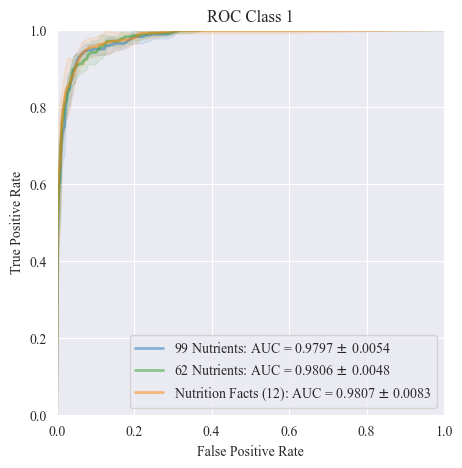

In [16]:
# target 1 specific class
cc=0
mean_fprL=[mean_fprWNP, mean_fprSR, mean_fprNF]
mean_tprL=[mean_tprWNP[cc], mean_tprSR[cc], mean_tprNF[cc]]
std_tprL=[std_tprWNP[cc], std_tprSR[cc], std_tprNF[cc]]
tprs_upperL=[tprs_upperWNP[cc], tprs_upperSR[cc], tprs_upperNF[cc]]
tprs_lowerL=[tprs_lowerWNP[cc], tprs_lowerSR[cc], tprs_lowerNF[cc]]
performancesAUCL=[performancesAUCWNP[:,cc], performancesAUCSR[:,cc], performancesAUCNF[:,cc]]
labeld=['99 Nutrients', '62 Nutrients', 'Nutrition Facts (12)']
colord=[np.array([31,120,180])/255,  np.array([51,160,44])/255, np.array([255,127,0])/255]
ROCMultiPlot(mean_fprL, mean_tprL, std_tprL, tprs_upperL, tprs_lowerL, performancesAUCL, cc, labeld, colord)

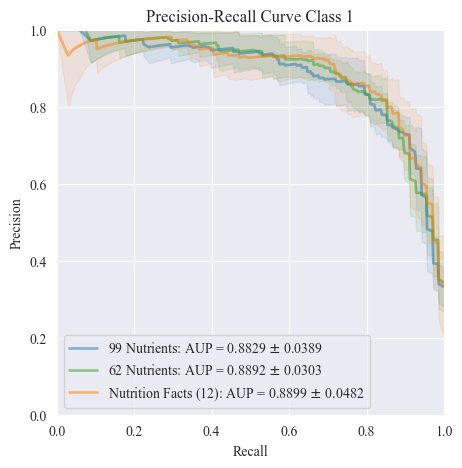

In [17]:
# target 1 specific class
cc=0
mean_recallL=[mean_recallWNP, mean_recallSR, mean_recallNF]
mean_precisionL=[mean_precisionWNP[cc], mean_precisionSR[cc], mean_precisionNF[cc]]
std_precisionL=[std_precisionWNP[cc], std_precisionSR[cc], std_precisionNF[cc]]
precision_upperL=[precision_upperWNP[cc], precision_upperSR[cc], precision_upperNF[cc]]
precision_lowerL=[precision_lowerWNP[cc], precision_lowerSR[cc], precision_lowerNF[cc]]
performancesAUPL=[performancesAUPWNP[:,cc], performancesAUPSR[:,cc], performancesAUPNF[:,cc]]
labeld=['99 Nutrients', '62 Nutrients', 'Nutrition Facts (12)']
colord=[np.array([31,120,180])/255,  np.array([51,160,44])/255, np.array([255,127,0])/255]
PrecisionRecallMultiPlot(mean_recallL, mean_precisionL, std_precisionL, precision_upperL, precision_lowerL, performancesAUPL, cc, labeld, colord)

# Summary Panel

In [18]:
colorclass=[np.array([0.4, 0.7607843137254902, 0.6470588235294118]), np.array([0.9882352941176471, 0.5529411764705883, 0.3843137254901961]),np.array([0.5529411764705883, 0.6274509803921569, 0.796078431372549]), np.array([0.9058823529411765, 0.5411764705882353, 0.7647058823529411])]

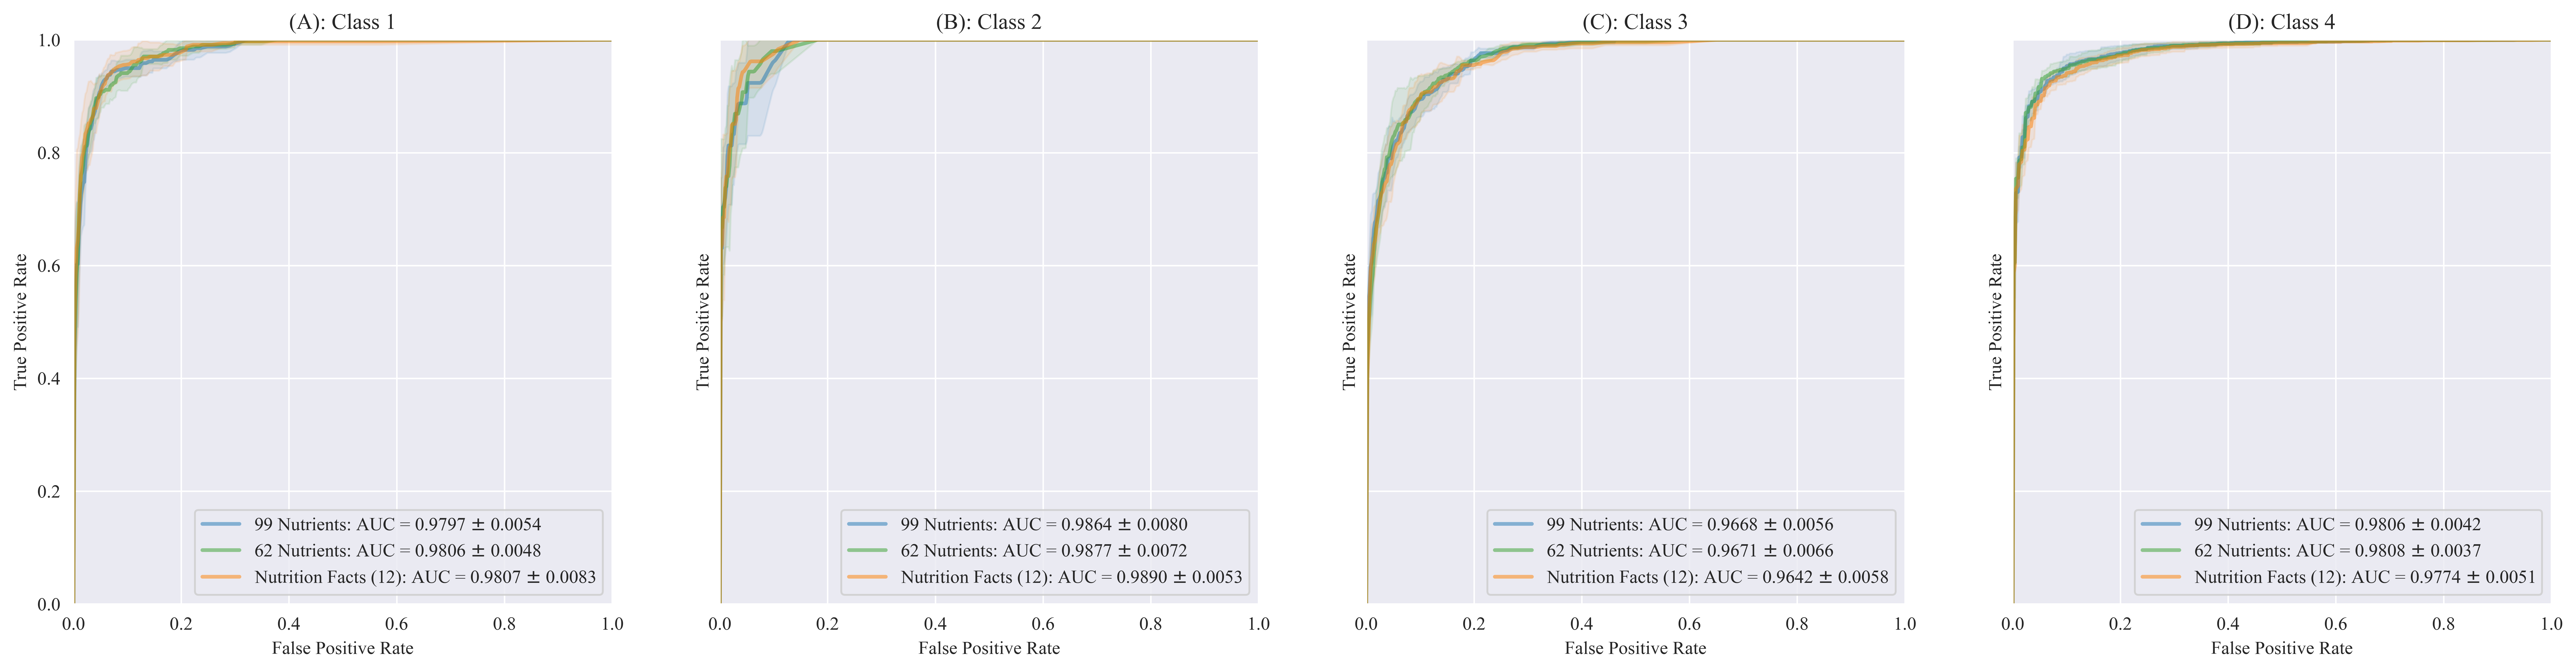

In [19]:
# subplots ROC
numclass=4
panelletter=['(A): ', '(B): ','(C): ', '(D): ' ]
fig, axes = plt.subplots(1, numclass, figsize=(24,5.5), dpi=600, sharex=True, sharey=True)
for cc,ax in enumerate(axes.flatten()):
    mean_fprL=[mean_fprWNP, mean_fprSR, mean_fprNF]
    mean_tprL=[mean_tprWNP[cc], mean_tprSR[cc], mean_tprNF[cc]]
    std_tprL=[std_tprWNP[cc], std_tprSR[cc], std_tprNF[cc]]
    tprs_upperL=[tprs_upperWNP[cc], tprs_upperSR[cc], tprs_upperNF[cc]]
    tprs_lowerL=[tprs_lowerWNP[cc], tprs_lowerSR[cc], tprs_lowerNF[cc]]
    performancesAUCL=[performancesAUCWNP[:,cc], performancesAUCSR[:,cc], performancesAUCNF[:,cc]]
    ROCMultiPlotCallable(mean_fprL, mean_tprL, std_tprL, tprs_upperL, tprs_lowerL, performancesAUCL, cc, labeld, colord,ax)
    ax.set(xlim=[0, 1], ylim=[0, 1], title=panelletter[cc]+"Class "+ str(cc+1))   
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')

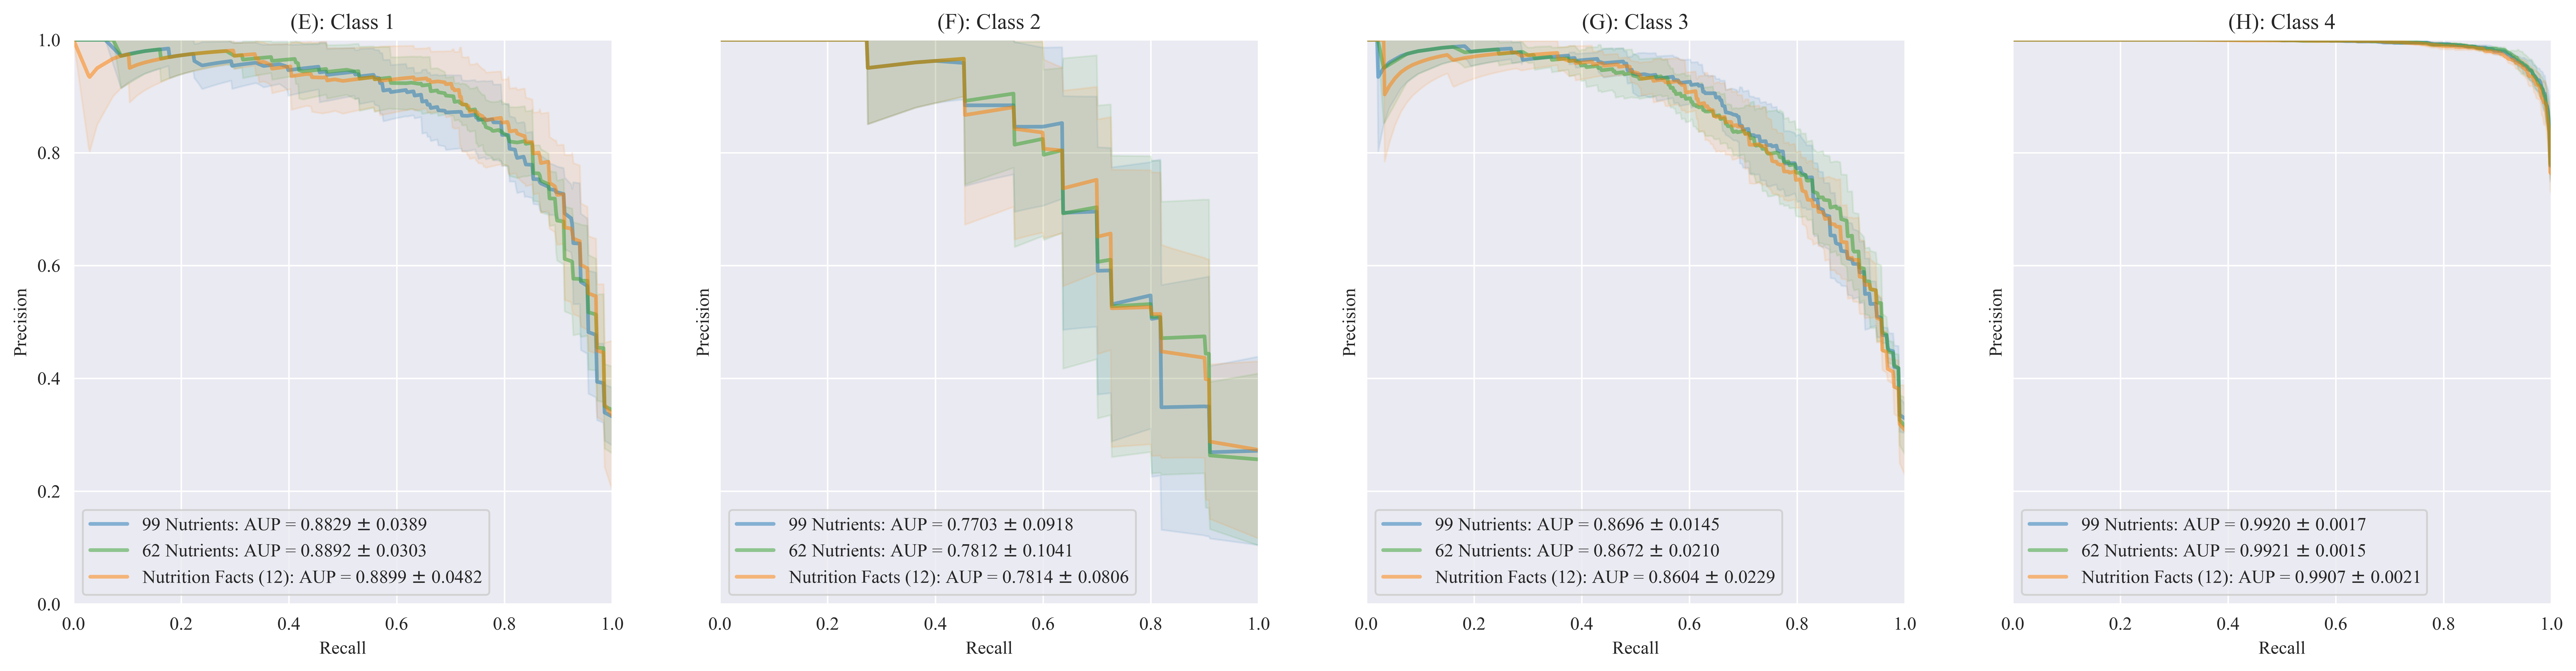

In [20]:
# subplots Precision Recall curve
numclass=4
panelletter=['(E): ', '(F): ','(G): ', '(H): ' ]
fig, axes = plt.subplots(1, numclass, figsize=(24,5.5), dpi=600, sharex=True, sharey=True)
for cc,ax in enumerate(axes.flatten()):
    mean_recallL=[mean_recallWNP, mean_recallSR, mean_recallNF]
    mean_precisionL=[mean_precisionWNP[cc], mean_precisionSR[cc], mean_precisionNF[cc]]
    std_precisionL=[std_precisionWNP[cc], std_precisionSR[cc], std_precisionNF[cc]]
    precision_upperL=[precision_upperWNP[cc], precision_upperSR[cc], precision_upperNF[cc]]
    precision_lowerL=[precision_lowerWNP[cc], precision_lowerSR[cc], precision_lowerNF[cc]]
    performancesAUPL=[performancesAUPWNP[:,cc], performancesAUPSR[:,cc], performancesAUPNF[:,cc]]
    PrecisionRecallMultiPlotCallable(mean_recallL, mean_precisionL, std_precisionL, precision_upperL, precision_lowerL, performancesAUPL, cc, labeld, colord,ax)
    ax.set(xlim=[0, 1], ylim=[0, 1], title=panelletter[cc]+"Class "+ str(cc+1))   
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')

# Performance Summary Table

In [22]:
dataAUC=np.array([performancesAUCNF.mean(axis=0),performancesAUCNF.std(axis=0),
 performancesAUCSR.mean(axis=0), performancesAUCSR.std(axis=0), 
 performancesAUCWNP.mean(axis=0), performancesAUCWNP.std(axis=0),
 np.array([performancesAUCNF.mean(axis=0),performancesAUCSR.mean(axis=0), performancesAUCWNP.mean(axis=0)]).mean(axis=0),
 np.array([performancesAUCNF.mean(axis=0),performancesAUCSR.mean(axis=0), performancesAUCWNP.mean(axis=0)]).std(axis=0)])

df = pd.DataFrame(data=dataAUC, index=["Average AUC Nutrition Facts", "Std AUC Nutrition Facts", "Average AUC 62 Nutrients", "Std AUC 62 Nutrients","Average AUC 99 Nutrients", "Std AUC 99 Nutrients", "Average AUC", "Std AUC"],
                  columns=["NOVA 1", "NOVA 2", "NOVA 3", "NOVA 4"])
df

,NOVA 1,NOVA 2,NOVA 3,NOVA 4
Average AUC Nutrition Facts,0.980663,0.989036,0.964169,0.977367
Std AUC Nutrition Facts,0.008347,0.005334,0.005846,0.005067
Average AUC 62 Nutrients,0.980578,0.987651,0.967059,0.980788
Std AUC 62 Nutrients,0.004781,0.007234,0.006620,0.003749
Average AUC 99 Nutrients,0.979663,0.986354,0.966794,0.980563
Std AUC 99 Nutrients,0.005429,0.007995,0.005588,0.004161
Average AUC,0.980301,0.987681,0.966007,0.979573
Std AUC,0.000453,0.001095,0.001304,0.001562


In [23]:
'a'

'a'

In [17]:
dataAUP=np.array([performancesAUPNF.mean(axis=0),performancesAUPNF.std(axis=0),
 performancesAUPSR.mean(axis=0), performancesAUPSR.std(axis=0), 
 performancesAUPWNP.mean(axis=0), performancesAUPWNP.std(axis=0),
 np.array([performancesAUPNF.mean(axis=0),performancesAUPSR.mean(axis=0), performancesAUPWNP.mean(axis=0)]).mean(axis=0),
 np.array([performancesAUPNF.mean(axis=0),performancesAUPSR.mean(axis=0), performancesAUPWNP.mean(axis=0)]).std(axis=0)])

df = pd.DataFrame(data=dataAUP, index=["Average AUP Nutrition Facts", "Std AUP Nutrition Facts", "Average AUP 62 Nutrients", "Std AUP 62 Nutrients","Average AUP 99 Nutrients", "Std AUP 99 Nutrients", "Average AUP", "Std AUP"],
                  columns=["NOVA 1", "NOVA 2", "NOVA 3", "NOVA 4"])
df

,NOVA 1,NOVA 2,NOVA 3,NOVA 4
Average AUP Nutrition Facts,0.891112,0.756997,0.864605,0.990558
Std AUP Nutrition Facts,0.035105,0.169225,0.040566,0.001414
Average AUP 62 Nutrients,0.891971,0.736245,0.873025,0.991702
Std AUP 62 Nutrients,0.024412,0.185744,0.039220,0.002178
Average AUP 99 Nutrients,0.881419,0.747070,0.879123,0.991783
Std AUP 99 Nutrients,0.024092,0.193387,0.032601,0.001954
Average AUP,0.888168,0.746770,0.872251,0.991348
Std AUP,0.004785,0.008475,0.005952,0.000560
